In [60]:
import tensorflow as tf
import glob, os, sys
from keras.models import load_model
import cv2 #cv2 requiered for selective search on images
import matplotlib.pyplot as plt
import numpy as np
from sputum_detection_model import SputumDetectionModel
from PIL import Image

import annotations
from annotations.object_detection import ImageForObjectDetection
from annotations import db
from pathlib import Path
import dotenv, os

import json, requests

dotenv.load_dotenv('.env')
session = db.get_session(os.environ.get("DATABASE_URI"))
model_dir = 'ml-models/sputum_detection/'
img_dir = 'data/tuberculosis-phonecamera'
imgs = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
# img = Image.open(imgs[0])
# img = np.array(img)
sys.path.append(model_dir)

%matplotlib inline

12 annotations
(1224, 1632, 3) 1224


<Axes: >

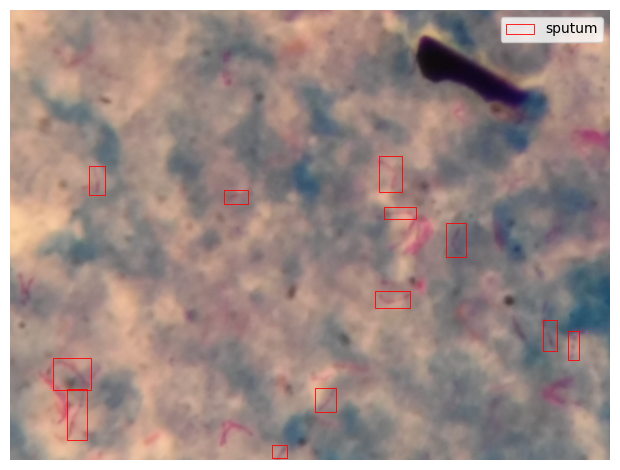

In [68]:
artifact = session.query(db.Artifact).filter(db.Artifact.name == Path(imgs[0]).stem).first()
image = ImageForObjectDetection.from_db(artifact)
print(len(artifact.annotations),"annotations")
img = image.numpy()
print(img.shape, len(img.tolist()))
image.display()

In [67]:
img = Image.open(image.uri)
img.size

(1632, 1224)

Predict with the served application

In [ ]:
%%time

headers = {"Content-Type": "application/json"}
serving_uri = "http://127.0.0.1:8888/predict"

data = {"data": img.tolist()}
resp = requests.post(serving_uri, json=data, headers=headers)
resp.raise_for_status()
pred = resp.json()
SputumDetectionModel.plot_rects(img, pred['bboxes'], pred['confidences'])

Predict locally

In [900]:
model_keras = load_model('ml-models/sputum_detector/models/rcnn_MNasNet_2.h5')
model = SputumDetectionModel(model_keras)
# test_imgs = glob.glob('esputos/images/Test/*.jpg')

In [936]:
chunks_b[img_ind].shape

(80, 80, 3)

1131 1271
(0, 0, 80, 80) (0, 0, 80, 80)


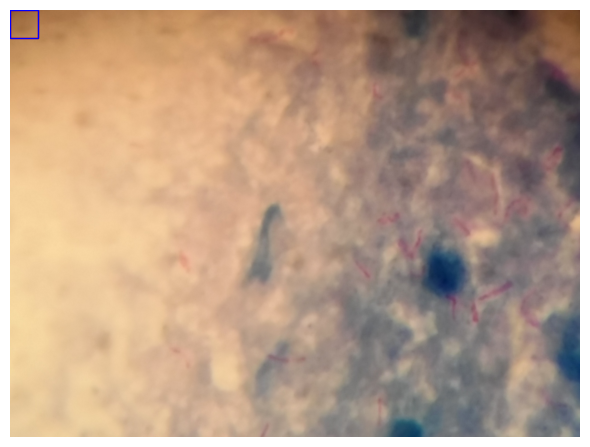

In [940]:
from matplotlib import patches
from typing import Tuple

def get_chunk_coords_in_img(ind, img, stride):
    x = (ind // img.shape[1]) * stride
    y = (ind % img.shape[1]) * stride
    return x, y

def detect_patch_in_img(img, patch) -> Tuple[int, int, int, int]:
    """
    Take a patch of image and return the bounding box coordinates of th exact match in the image
    """
    w, h = patch.shape[:2]
    for y in range(img.shape[0] - h):
        for x in range(img.shape[1] - w):
            if np.array_equal(img[y:y+h, x:x+w], patch):
                return x, y, w, h

img_ind = 0
chunk_size, stride = 80, 40
chunks_a, coords_a = model._preprocess_fast(img)
chunks_b, coords_b = model._preprocess_safe(img)
print(len(chunks_a), len(chunks_b))

padded_img = model._pad_img(img)
scaled_img = model._scale_img(img)
bbox_a = detect_patch_in_img(scaled_img, chunks_a[img_ind])
if bbox_a is None:
    print("No match found for chunks_a in image")
bbox_b = detect_patch_in_img(scaled_img, chunks_b[img_ind])
if bbox_b is None:
    print("No match found for chunks_b in image")
print(bbox_a, bbox_b)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(scaled_img)
ax.add_patch(patches.Rectangle((bbox_a[0], bbox_a[1]), bbox_a[2], bbox_a[3], linewidth=1, edgecolor='r', facecolor='none'))
# ax2.imshow(img_pad[bbox_b[1]:(bbox_b[1]+chunk_size), bbox_b[0]:(bbox_b[0]+chunk_size)])
ax.add_patch(patches.Rectangle((bbox_b[0], bbox_b[1]), bbox_b[2], bbox_b[3], linewidth=1, edgecolor='b', facecolor='none'))
ax.axis('off')
fig.tight_layout()
plt.show()


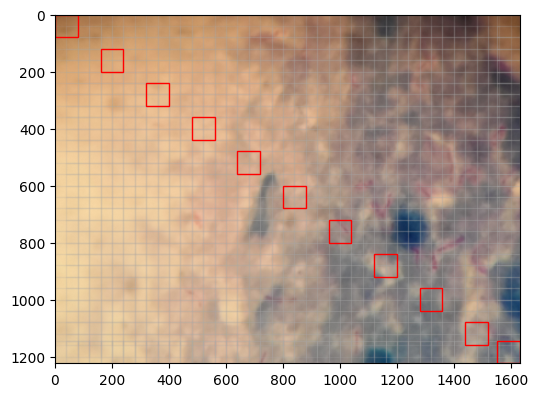

In [926]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img)
chunks, coords = model._preprocess_safe(img)
hind = len(coords)//10
for i,coord in enumerate(coords):
    ax.add_patch(plt.Rectangle(
        (coord[1], coord[0]), 
        chunk_size, chunk_size, 
        fill=False, lw=1, zorder=1 if i%hind>0 else 2,
        edgecolor='darkgrey' if i%hind>0 else 'red', 
        alpha=0.1 if i%hind>0 else 1.0
        )
    )
    
plt.show()

2023-08-10 21:40:31,200 - sputum_detection_model.predict - INFO - Predicting bounding boxes


38/38 [==============================] - 4s 90ms/step


2023-08-10 21:40:35,167 - sputum_detection_model.predict - INFO - Predicted 33 potential rects
2023-08-10 21:40:35,173 - sputum_detection_model.predict - INFO - A total of 12 bounding boxes were found


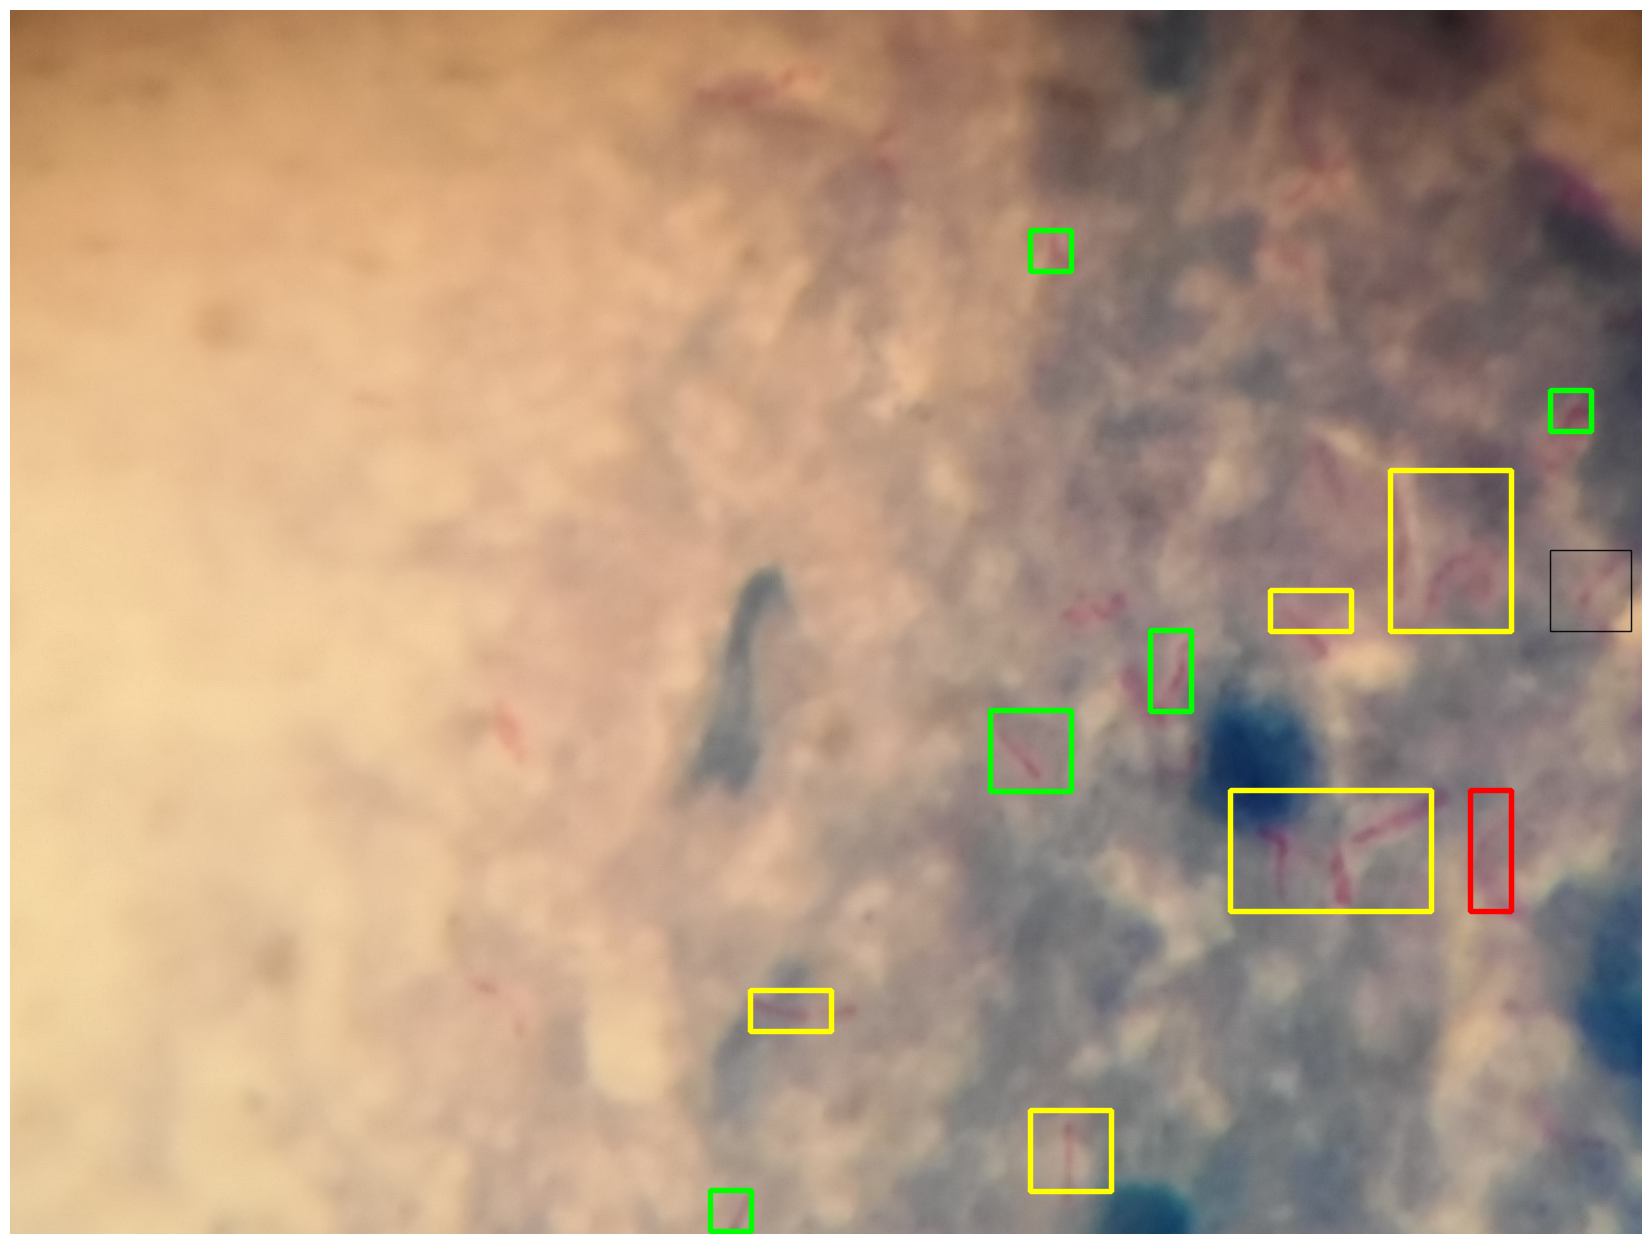

In [75]:
# %%time
th = 0.1
img = Image.open(imgs[1])
img = np.array(img)
boxes, conf = model.predict(img, merge_rects=True, th=th)
model.plot_rects(
    img, 
    boxes, conf,
    thresholds={
        0.3: (255, 0, 0), # red if confidence [0.5-0.75)
        0.5: (255, 255, 0), # yellow if confidence <0.9
        0.9: (0, 255, 0), # green if confidence >=0.9
    },
    plot_lower=True, # ignore boxes with confidence < the minimum threshold
    thickness=4
)

In [77]:
conf

array([0.18667638, 0.99500799, 0.60294306, 0.34879506, 0.64687836,
       0.86828303, 0.99999487, 0.84506625, 0.99980634, 0.9999876 ,
       0.67804813, 0.9999994 ])

In [4]:
from annotations.object_detection.rect import Rect, Rects, rectchange

old_rects_list = [{'left': 830.0, 'top': 1029.0, 'width': 56.0, 'height': 64.0, 'label': None}, {'left': 1002.0, 'top': 397.0, 'width': 64.0, 'height': 97.0, 'label': None}, {'left': 1185.0, 'top': 579.0, 'width': 56.0, 'height': 91.0, 'label': None}, {'left': 711.0, 'top': 1184.0, 'width': 41.0, 'height': 33.0, 'label': None}, {'left': 581.0, 'top': 488.0, 'width': 66.0, 'height': 39.0, 'label': None}, {'left': 116.0, 'top': 946.0, 'width': 103.0, 'height': 87.0, 'label': None}, {'left': 155.0, 'top': 1031.0, 'width': 54.0, 'height': 138.0, 'label': None}, {'left': 991.0, 'top': 765.0, 'width': 97.0, 'height': 45.0, 'label': None}, {'left': 1448.0, 'top': 843.0, 'width': 39.0, 'height': 85.0, 'label': None}, {'left': 1518.0, 'top': 872.0, 'width': 29.0, 'height': 79.0, 'label': None}, {'left': 1018.0, 'top': 534.0, 'width': 85.0, 'height': 33.0, 'label': None}, {'left': 215.0, 'top': 424.0, 'width': 42.0, 'height': 79.0, 'label': None}]
new_rects_list = [{'left': 739.0742857142857, 'width': 58.33142857142853, 'top': 735.24, 'height': 66.33142857142867, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 1002.0000000000001, 'width': 66.33142857142867, 'top': 397.0, 'height': 99.33142857142862, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 1185.0, 'width': 58.33142857142853, 'top': 579.0, 'height': 93.3314285714285, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 710.9999999999999, 'width': 43.33142857142865, 'top': 1184.0, 'height': 35.33142857142851, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 581.0, 'width': 68.33142857142852, 'top': 488.0, 'height': 41.33142857142862, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 115.99999999999999, 'width': 105.33142857142859, 'top': 946.0, 'height': 89.33142857142869, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 155.0, 'width': 56.33142857142856, 'top': 1031.0, 'height': 140.3314285714287, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 991.0, 'width': 99.33142857142862, 'top': 765.0, 'height': 47.33142857142846, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 1448.0, 'width': 41.331428571428354, 'top': 843.0, 'height': 87.33142857142866, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 1518.0, 'width': 31.331428571428436, 'top': 872.0, 'height': 81.33142857142855, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 1018.0, 'width': 87.33142857142866, 'top': 534.0, 'height': 35.33142857142851, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 215.0, 'width': 44.33142857142854, 'top': 424.0, 'height': 81.33142857142855, 'label': None, 'color': 'blue', 'annotation_id': None}, {'left': 561.8754125526478, 'width': 107.24458744735213, 'top': 1107.4285714285713, 'height': 69.36, 'label': '', 'color': 'blue', 'annotation_id': None}]
old_rects = Rects([Rect.create(**r) for r in old_rects_list])
new_rects = Rects([Rect.create(**r) for r in new_rects_list])
new_rects_poly = new_rects.shapely().buffer(0)
old_rects_poly = old_rects.shapely().buffer(0)

changed_rects = rectchange(old_rects, new_rects)
print(f"Number of rects added: {len(changed_rects.created)}/{len(new_rects)}")
print(f"Number of rects removed: {len(changed_rects.removed)}/{len(old_rects)}")

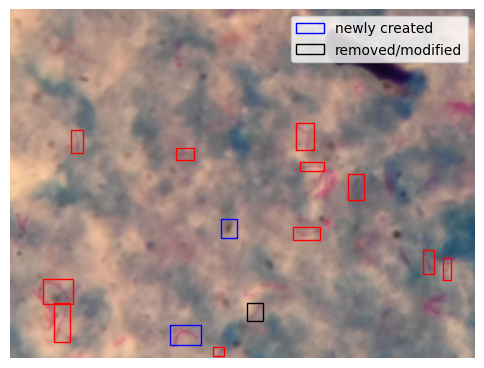

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img)
changed_rects.unmodified.plot(color='red', zorder=4, ax=ax)
changed_rects.created.plot(color='blue', zorder=4, ax=ax, label='newly created')
changed_rects.removed.plot(color='black', zorder=4, ax=ax, label='removed/modified')
ax.axis('off')
plt.legend()

In [2]:
from pydantic import BaseModel, Field
from typing import List, Union

class ObjectDetectionState(BaseModel):
    session_id: str = None
    project_id: int = None
    annotator_id:int = None
    current_artifact_id:int = None
    current_artifact_uri:str = None 
    selected_annotation_model:str = None
    previous_rects:List[dict] = Field(default_factory=dict)
    current_rects:List[dict] = Field(default_factory=dict)

    def __init__(self, **data):
        if "project" in data and "project_id" not in data:
            data["project_id"] = data["project"].id
        if "annotator" in data and "annotator_id" not in data:
            data["annotator_id"] = data["annotator"].id
        if data.get("current_artifact", data.get("artifact")) is not None:
            curr_artifact = data.pop("current_artifact", data.pop("artifact"))
            if "current_artifact_id" not in data:
                data["current_artifact_id"] = curr_artifact.id
            if "current_artifact_uri" not in data:
                data["current_artifact_uri"] = curr_artifact.uri

        if "previous_rects" in data:
            data['previous_rects'] = Rects(rects=[Rect.create(rect) for rect in data['previous_rects']])
        if "current_rects" in data:
            data['current_rects'] = Rects(rects=[Rect.create(rect) for rect in data['current_rects']])
        data['previous_rects'] = data['previous_rects'].todict()
        data['current_rects'] = data['current_rects'].todict()
        super().__init__(**data)

In [57]:
session_id = "89e37918-80a7-4bf1-b37c-d5987fe1a541"
project_id = 1
project = session.query(db.Project).filter_by(id=project_id).first()
annotator = project.annotators[0]
artifact = project.artifacts[0]
annotation_model = session.query(db.Annotator.name).where(db.Annotator.automatic).first()[0]

session_state = {
    "session_id": session_id,
    "project": project,
    "annotator": annotator,
    "artifact": artifact,
    "annotation_model": annotation_model,
    "previous_rects": old_rects.todict(),
    "current_rects": new_rects.todict(),
    "other_kwargs": [1,2,3]
}

In [5]:
od_state = ObjectDetectionState(**session_state)

session_state_db = db.SessionState(
    session_id=session_id,
    project_id=project.id,
    annotator_id=annotator.id,
    session_state=od_state.dict(),
)

session.add(session_state_db)
session.commit()

db.utils.to_df(session.query(db.SessionState).all())

# prev_rects_sess = Rects(sess_state.get('previous_rects', []))
# curr_rects_sess = Rects(sess_state.get('current_rects', []))
# change = rectcstate(curr_rects_sess, prev_rects_sess).identify_change()
# ax = change.unmodified.plot(color='blue', label='updated')
# change.removed.plot(color='red', label='deleted', ax=ax)
# change.created.plot(color='green', label='created', ax=ax)
# ax.set_title("Change in Rects")
# ax.legend()
# ax.imshow(img)


NameError: name 'session_id' is not defined

(0.0, 1547.0, 1217.0, 0.0)

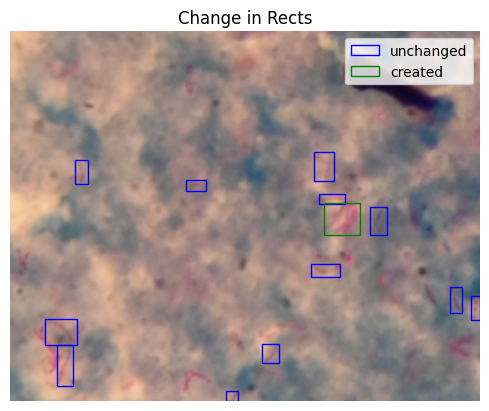

In [56]:
from annotations.object_detection.rect import Rects, rectchange

labeling_session_latest = (
    session.query(db.SessionState)
    # .where(db.SessionState.session_id == "1a32b6a4-ac3c-485b-8065-89330f70557a")
    .order_by(db.SessionState.created_at.desc())
    .first()
)
if labeling_session_latest is None:
    raise ValueError("No session found with that ID.")
session_state = labeling_session_latest.session_state
img = Image.open(session_state.get('current_artifact_uri'))
prev_rects_sess = Rects(session_state.get('previous_rects', []))
curr_rects_sess = Rects(session_state.get('current_rects', []))
change = rectchange(prev_rects_sess, curr_rects_sess)
ax = change.unmodified.plot(color='blue', label='unchanged')
change.removed.plot(color='red', label='deleted', ax=ax)
change.created.plot(color='green', label='created', ax=ax)
ax.set_title("Change in Rects")
ax.legend()
ax.imshow(img)
ax.axis('off')

In [55]:
change.rects[0].meta

{}